# 9/19 DE 팀 과제 스크립트
## 이번 과제는 csv/parquet, spark/pandas 의 성능 비교 입니다.

In [31]:
sc

<SparkContext master=local[*] appName=PySparkShell>

# apache arrow
## apache arrow를 이용하여 csv 를 parquet file로 변환하기
https://arrow.apache.org/

In [32]:
import pyarrow
import pandas as pd
from pyarrow import csv, parquet

In [33]:
exhibition_pd_df = pd.read_csv("./data/artfacts_exhibitions.csv")

In [34]:
exhibition_pd_df.head()

,id,type,title,city,country,institution,begin_date,end_date,artists,curators
0,2,G,Adapted Land,87.0,2.0,4.0,1999-04-13,1999-05-10,"[{""id"": ""45"", ""name"": ""Wolf Vostell""}, {""id"": ...",NaN
1,3,S,Katharina Grosse,24.0,1.0,47.0,1999-03-06,1999-04-24,"[{""id"": ""112"", ""name"": ""Katharina Grosse""}]",NaN
2,4,G,10 Jahre Galerie Schwind - Bilder und Skulpturen,30.0,1.0,293.0,1999-03-07,1999-04-14,"[{""id"": ""152"", ""name"": ""Wieland F\u00f6rster""}...",NaN
3,5,S,Ann Reder - Plastiken und Arbeiten auf Papier,30.0,1.0,308.0,1999-03-13,1999-04-30,"[{""id"": ""3151"", ""name"": ""Ann Reder""}]",NaN
4,6,S,Kay Hassan - Konstruktive Collagen,44.0,1.0,307.0,1999-03-13,1999-04-27,"[{""id"": ""3152"", ""name"": ""Kay Hassan""}]",NaN


#### parquet은 정형 데이터 타입입니다 따라서 스키마를 지정해서 저장을 해줘야합니다.
#### csv를 읽어서 column에 대한 간단한 정보를 확인했으니, parquet로 변환할때 필요한 스키마를 지정해 줍니다

위 데이터는 artfacts 라는 사이트의 exhibition를 크롤링한 데이터입니다. artfacts는 전세계 화가에 대한 정보 제공하고 있는 사이트 입니다.

* id: 전시회의 고유 아이디
* type: 전시회의 타입 (S: 솔로 전시회, G: 그룹 전시회, B: 비엔날레 등등)
* city: 전시회가 열린 도시의 아이디 
* institution: 전시회의 아이디
* begin_date: 전시회 시작 날짜 
* end_date: 전시회 종료 날짜
* artist: 참여한 화가에 대한 정보
* curators: 전시회를 담당한 큐레이터의 정보

### artfacts_exhibition.csv 의 용량은 244mb 정도이고 row 개수는 80만개 정도로 작은 데이터는 아닙니다.  

#### 1) csv에서 읽은 데이터를 parquet로 변형하는 과정에서 필요한 스키마를 지정해 줍니다!

In [35]:
Schema = {
    "id": pyarrow.int32(),
    "type":pyarrow.string(),
    "title":pyarrow.string(),
    "city":pyarrow.int32(),
    "country":pyarrow.int32(),
    "institution":pyarrow.int32(),
    "begin_date":pyarrow.date32(),
    "end_date":pyarrow.date32(),
    "artists":pyarrow.string(),
    "curators":pyarrow.string(),
}

#### 2) 컬럼명과 타입을 연결하는 pyarrow field 객체를 생성해 주는 함수를 작성합니다.

아래는 pyarrow 공식 도큐에 나온 함수 설명입니다
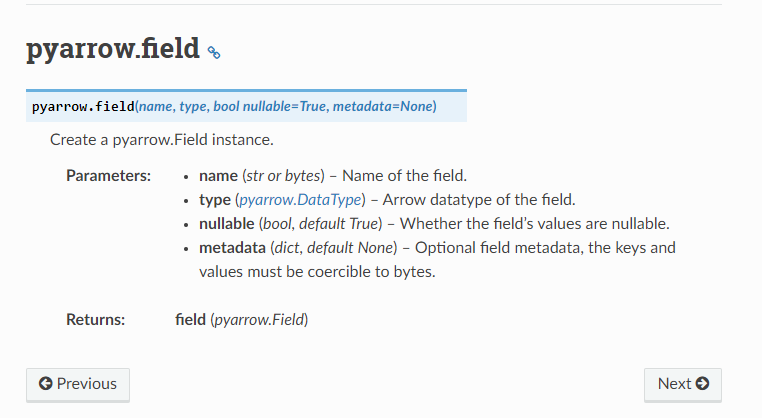

In [36]:
def field_mapper(column_name: str):
    return pyarrow.field(column_name, Schema[column_name])

#### 3) 위에서 생성한 field_mapper 함수를 이용해 parquet_table에 schema를 부여해주는 함수를 작성합니다.
파퀘 테이블을 인자로 받아 컬럼을 꺼내고 각 컬럼에 대해 타입을 매핑한 필드를 모아 스키마를 작성합니다


In [37]:
def generate_schema(parquet_table):
    fields = []
    for column_name in parquet_table.schema:
        column = column_name.name
        fields.append(field_mapper(column))
    return pyarrow.schema(fields)

#### 4) pyarrow를 이용하여 csv 파일을 테이블 객체로 읽어옵니다. 이후 저희가 만든 스키마로 값들을 던지도록 할게요  

In [38]:
csv_table = csv.read_csv("./data/artfacts_exhibitions.csv")
csv_table = csv_table.cast(generate_schema(csv_table))

#### 5) 위의 과정을 통해 csv에 schema를 부여하고 parquet로 저장할 준비가 끝났습니다
#### pyarrow 의 parquet를 이용해 위의 csv_table을 parquet파일로 저장하겠습니다.

In [39]:
parquet.write_table(csv_table, "./data/artfacts_exhibitions", compression="snappy")

#### 6) parquet 과 csv에서 만들어온 임시테이블을 이용하야 똑같은 쿼리를 사용하여 성능 비교

csv와 parquet 에서 각각 데이터를 읽어와 스파크 임시 테이블로 지정   
왜 임시테이블이라고 할까? 실제로 연산이 일어나기 전까지 데이터를 읽어오지 않습니다
### 이유는 스파크의 지연연산!!
load부분에 데이터가 저장된 올바른 경로를 지정해 줍니다

In [40]:
spark.read.format("csv")\
.option("header","true")\
.load("file:///home/ubuntu/ybigta/2020_09_19_spark-datasource/data/artfacts_exhibitions.csv")\
.registerTempTable("exhibitions_csv")

spark.read.format("parquet")\
.load("file:///home/ubuntu/ybigta/2020_09_19_spark-datasource/data/artfacts_exhibitions")\
.registerTempTable("exhibitions_parquet")

#### 6-1) 각 함수의 시간을 비교하기 위해 파이썬 데코레이터를 활용해 봅시다! 
데코레이터는 파이썬 고급 문법중 하나로서 잘 활용한다면 중복되는 코드를 상당히 줄일 수 있습니다. 
간단하게 함수를 인자로 받아 그 함수를 데코레이팅 즉 꾸며두는 역할을 합니다

아래는 artfacts exhibition 정보를 국가, 도시, 타입 별로 몇번 전시회가 일어났는지에 대한 테이블을 만들고, top5를 보여주는 함수입니다.

In [41]:
from functools import wraps
import time
def loading_time(func):
    @wraps(func)
    def wrapper(*args, **kwargs):
        start = time.time()
        result = func(*args, **kwargs)
        end = time.time()
        print(f"function[{func.__name__}] : {end - start} S")
        return result
    return wrapper 

In [42]:
@loading_time
def group_by_test_csv():
    df = spark.sql("""
    SELECT country, city, type, count(id)
    FROM exhibitions_csv 
    GROUP BY 1, 2, 3
    ORDER BY 4 DESC
    """)
    df.show(5)

In [43]:
@loading_time
def group_by_test_parquet():
    df = spark.sql("""
    SELECT country, city, type, count(id)
    FROM exhibitions_parquet 
    GROUP BY 1, 2, 3
    ORDER BY 4 DESC
    """)
    df.show(5)

In [44]:
group_by_test_csv()

+-------+----+----+---------+
|country|city|type|count(id)|
+-------+----+----+---------+
|   18.0|59.0|   S|    45530|
|    1.0|12.0|   S|    21520|
|   14.0| 2.0|   S|    20104|
|   15.0|63.0|   S|    18924|
|   18.0|59.0|   G|    17282|
+-------+----+----+---------+
only showing top 5 rows

function[group_by_test_csv] : 8.22805905342102 S


In [45]:
group_by_test_parquet()

+-------+----+----+---------+
|country|city|type|count(id)|
+-------+----+----+---------+
|     18|  59|   S|    49745|
|      1|  12|   S|    24142|
|     14|   2|   S|    21756|
|     15|  63|   S|    20639|
|     18|  59|   G|    18874|
+-------+----+----+---------+
only showing top 5 rows

function[group_by_test_parquet] : 1.3913815021514893 S


스파크에서 파퀘를 이용했을때 1/4이하로 시간이 줄어드는 것을 확인할 수 있습니다.  
물론 row 단위로 작업을 해야하는 몇몇 작업들에 대해서는 큰 성능의 향상을 기대하기 힘들 수 있고, 또한 오히려 악화 될 수 도 있습니다.

### 과제1: apache arrow에 대해서 간단하게 정리하기
### 과제2: data 폴더에 있는 nation.csv파일을 parquet 파일로 변형해서 저장하기

In [16]:
#### 코드를 작성해서 진행해주세요 ~ 